In [13]:
import tensorflow as tf

In [14]:
!nvidia-smi

Tue Mar 25 11:51:37 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.70                 Driver Version: 572.70         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   45C    P3             11W /   30W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [15]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from tqdm import tqdm

In [ ]:
DATADIR = r"C:\Users\New Asus\Documents\FIT4701_2025_Sem1\training_img_dataset\front_dataset\front_vision"

CATEGORIES = ["clap", "jump", "nopeople", "punching", "pushpull", "rubhand", "squatting", "standing", "twist", "waving"]

for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
        # plt.imshow(img_array, cmap='gray')  # graph it
        # plt.show()  # display!

        break  # we just want one for now so break
    break  #...and one more!
 

In [18]:
IMG_SIZE = 64

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
# plt.imshow(new_array, cmap='gray')

In [19]:
training_data = []

def create_training_data():
    for category in CATEGORIES:

        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass

create_training_data()

print(len(training_data))

  0%|          | 0/1210 [00:00<?, ?it/s]

100%|██████████| 1210/1210 [00:02<00:00, 468.34it/s]

12095


In [20]:
import random

random.shuffle(training_data)

In [21]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)  # Convert y to NumPy array

In [22]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [23]:
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

In [24]:
X = X/255.0
y = to_categorical(y, num_classes=10)

In [25]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [26]:
cnn.compile(  loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [27]:
history = cnn.fit(X, y, epochs=10, validation_split=0.25)
split_idx = int(0.75 * len(X))  # 75% training, 25% validation
X_val = X[split_idx:]
y_val = y[split_idx:]

val_loss, val_acc = cnn.evaluate(X_val, y_val)
print(f"Final Validation Accuracy: {val_acc}")

Epoch 1/10
284/284 [==============================] - 29s 26ms/step - loss: 1.8160 - accuracy: 0.3473 - val_loss: 1.3698 - val_accuracy: 0.5172
Epoch 2/10
284/284 [==============================] - 4s 15ms/step - loss: 1.1829 - accuracy: 0.5838 - val_loss: 1.1775 - val_accuracy: 0.5866
Epoch 3/10
284/284 [==============================] - 5s 17ms/step - loss: 0.9384 - accuracy: 0.6718 - val_loss: 0.9893 - val_accuracy: 0.6511
Epoch 4/10
284/284 [==============================] - 5s 17ms/step - loss: 0.8121 - accuracy: 0.7225 - val_loss: 0.9193 - val_accuracy: 0.6822
Epoch 5/10
284/284 [==============================] - 5s 17ms/step - loss: 0.6861 - accuracy: 0.7665 - val_loss: 0.9002 - val_accuracy: 0.6935
Epoch 6/10
284/284 [==============================] - 5s 16ms/step - loss: 0.5965 - accuracy: 0.7947 - val_loss: 0.9534 - val_accuracy: 0.6858
Epoch 7/10
284/284 [==============================] - 5s 17ms/step - loss: 0.5028 - accuracy: 0.8296 - val_loss: 0.9466 - val_accuracy: 0.695

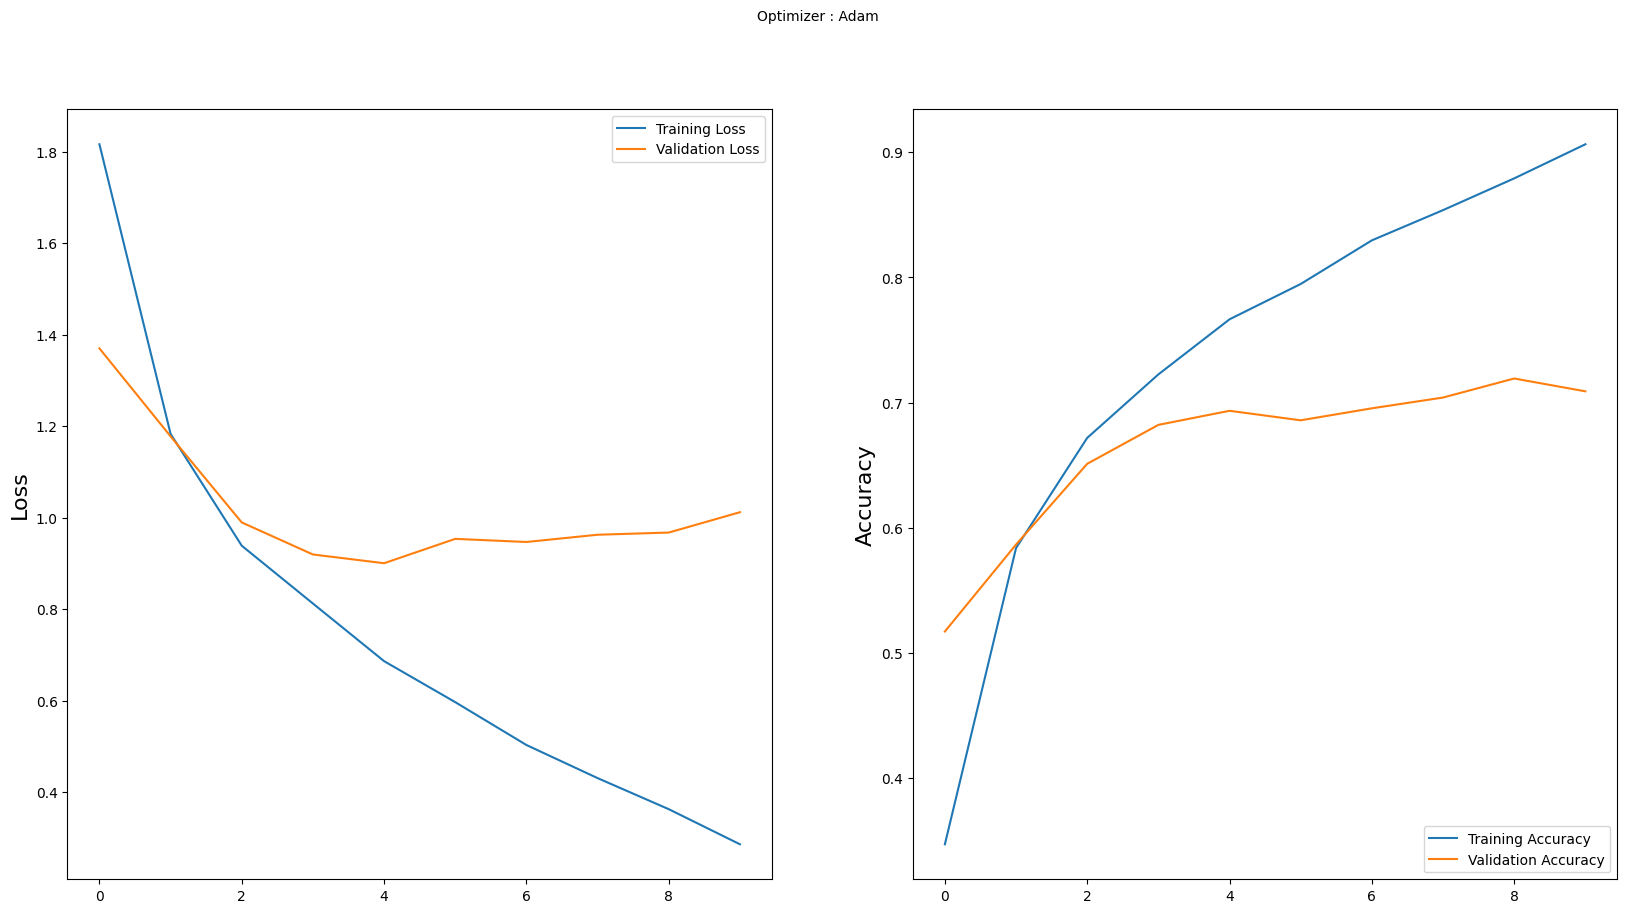

In [28]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()